In [45]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

import automembrane.util as u
from automembrane.energy import getEnergy2DClosed, getEnergy2DOpen

from pathlib import Path

files = list(
    map(
        Path,
        [
            f"coordinates/{i}"
            for i in [
                "cell1/34D-grid2-s3-acta1_001_16.txt",
                "cell2/34D-grid3-ActA1_007_16.txt",
                "cell2/34D-grid3-ActA1_013_16.txt",
                "cell3/34D-grid2-s2_002_16.txt",
                "cell3/34D-grid2-s5_005_16.txt",
                "cell3/34D-grid3-ActA1_020_16.txt",
                "cell3/34D-grid3-s6_005_16.txt",
                "cell4/34D-grid2-s3_028_16.txt",
                "cell5/34D-grid3-ActA1_001_16.txt",
                "cell5/34D-grid3-ActA1_002_16.txt",
                "cell5/34D-grid3-ActA1_003_16.txt",
                "cell5/34D-grid3-ActA1_004_16.txt",
            ]
        ],
    )
)


parameters = {
    "Kb": 2,  # Bending modulus
    "Kbc": 0,  # Constant of bending modulus vs protein density
    "Ksg": 0,  # Global stretching modulus
    "At": 0,  # Preferred area
    "epsilon": 0,  # Binding energy per protein
    "Kv": 0,  # pressure-volume modulus
    "Vt": 0,  # Volume target
}

u.matplotlibStyle(medium=10)


Processing: coordinates/cell1/34D-grid2-s3-acta1_001_16.txt
  Energy relaxation:


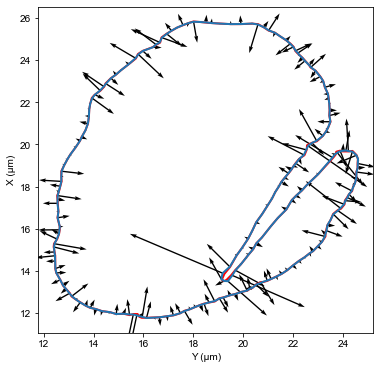

Processing: coordinates/cell2/34D-grid3-ActA1_007_16.txt
  Energy relaxation:


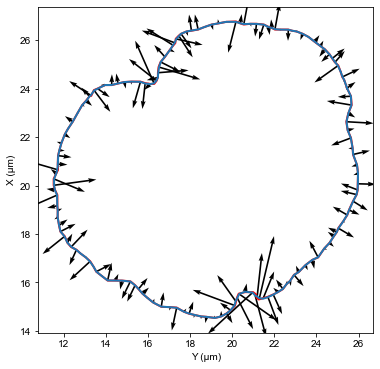

Processing: coordinates/cell2/34D-grid3-ActA1_013_16.txt
  Energy relaxation:


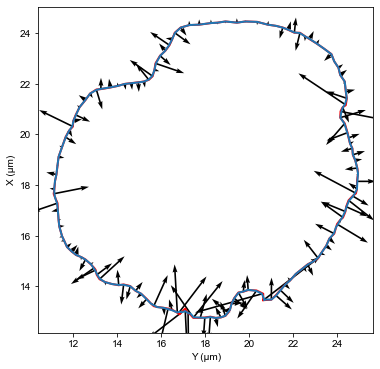

Processing: coordinates/cell3/34D-grid2-s2_002_16.txt
  Energy relaxation:


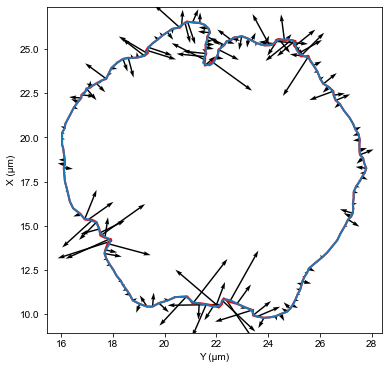

Processing: coordinates/cell3/34D-grid2-s5_005_16.txt
  Energy relaxation:


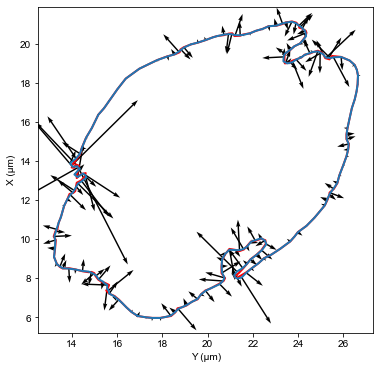

Processing: coordinates/cell3/34D-grid3-ActA1_020_16.txt
  Energy relaxation:


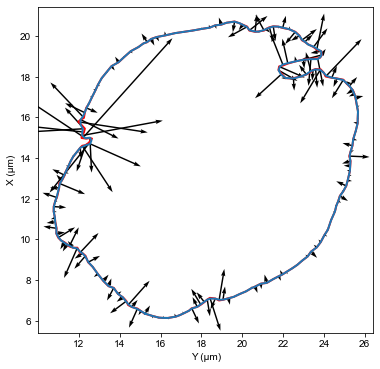

Processing: coordinates/cell3/34D-grid3-s6_005_16.txt
  Energy relaxation:


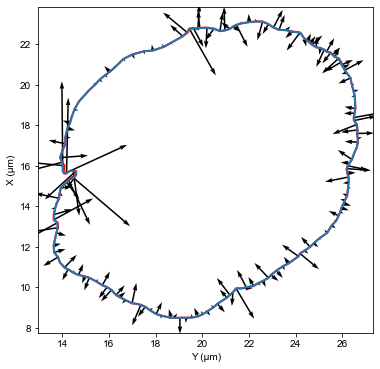

Processing: coordinates/cell4/34D-grid2-s3_028_16.txt
  Energy relaxation:


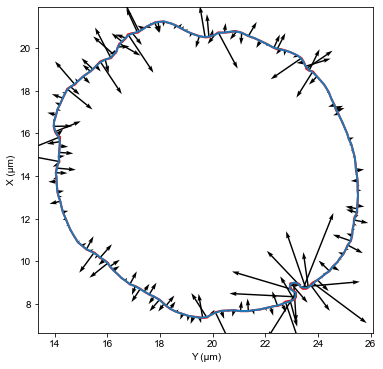

Processing: coordinates/cell5/34D-grid3-ActA1_001_16.txt
  Energy relaxation:


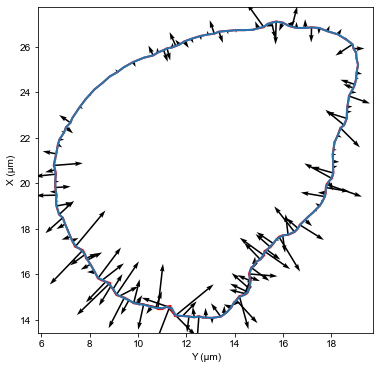

Processing: coordinates/cell5/34D-grid3-ActA1_002_16.txt
  Energy relaxation:


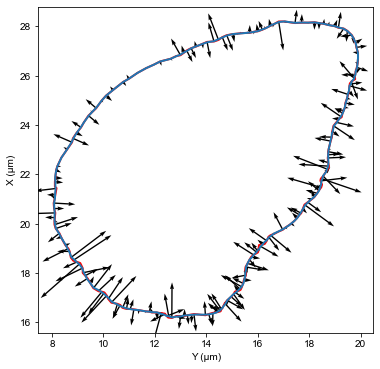

Processing: coordinates/cell5/34D-grid3-ActA1_003_16.txt
  Energy relaxation:


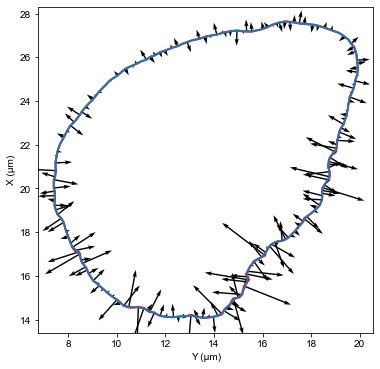

Processing: coordinates/cell5/34D-grid3-ActA1_004_16.txt
  Energy relaxation:


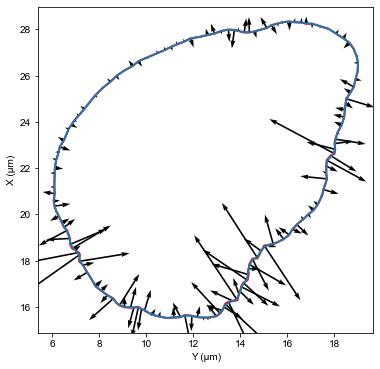

In [46]:
dt = 2e-5

f_energy = partial(getEnergy2DClosed, **parameters)

for file in files:
    print("Processing:", file)
    coords = np.loadtxt(file)
    coords = np.vstack((coords, coords[0]))  # Energy expects last point to equal first
    energy = f_energy(coords)

    relaxed_coords = coords
    
    print("  Energy relaxation:")
    for i in range(1, 50 + 1):
        energy = f_energy(relaxed_coords)
        # print(f"  - Iter. {i}:", energy)
        relaxed_coords = np.array(relaxed_coords - u.egrad(f_energy)(relaxed_coords) * dt)
        relaxed_coords[-1] = relaxed_coords[0]

    forces = - u.egrad(f_energy)(relaxed_coords)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.plot(coords[:,0], coords[:,1], color='r') 
    ax.plot(relaxed_coords[:, 0], relaxed_coords[:, 1])

    ax.quiver(
        relaxed_coords[:, 0],
        relaxed_coords[:, 1],
        forces[:, 0],
        forces[:, 1],
        label="force",
    )
    ax.set_ylabel(r"X (μm)")
    ax.set_xlabel(r"Y (μm)")
    plt.show()


Processing: coordinates/cell1/34D-grid2-s3-acta1_001_16.txt


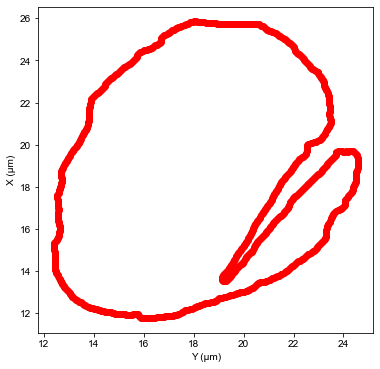

Processing: coordinates/cell2/34D-grid3-ActA1_007_16.txt


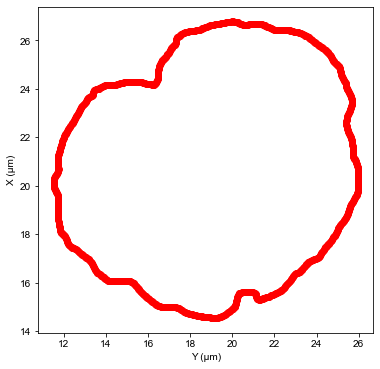

Processing: coordinates/cell2/34D-grid3-ActA1_013_16.txt


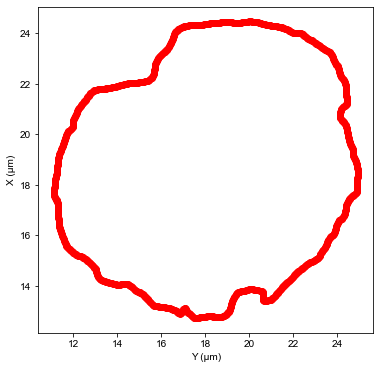

Processing: coordinates/cell3/34D-grid2-s2_002_16.txt


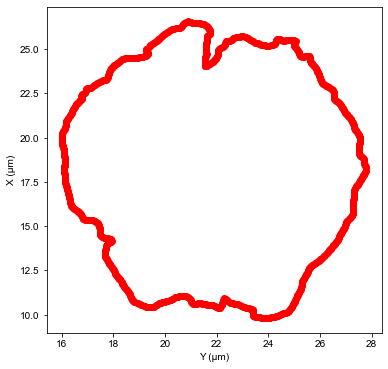

Processing: coordinates/cell3/34D-grid2-s5_005_16.txt


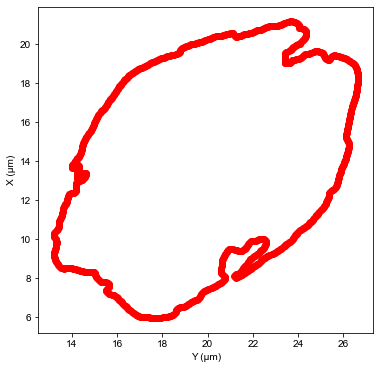

Processing: coordinates/cell3/34D-grid3-ActA1_020_16.txt


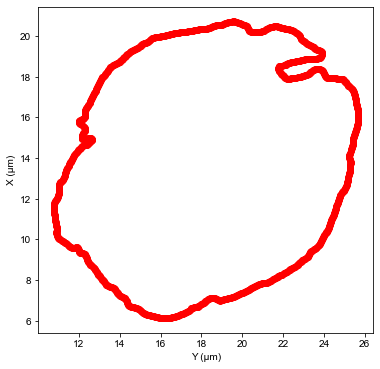

Processing: coordinates/cell3/34D-grid3-s6_005_16.txt


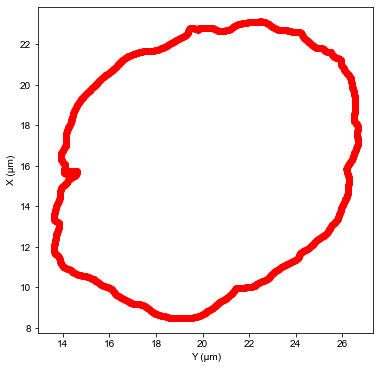

Processing: coordinates/cell4/34D-grid2-s3_028_16.txt


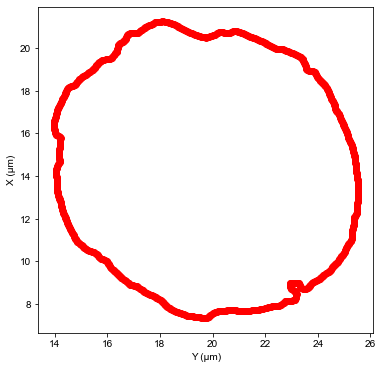

Processing: coordinates/cell5/34D-grid3-ActA1_001_16.txt


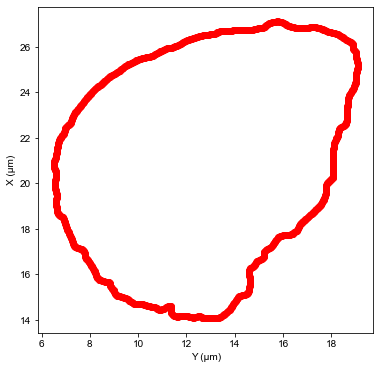

Processing: coordinates/cell5/34D-grid3-ActA1_002_16.txt


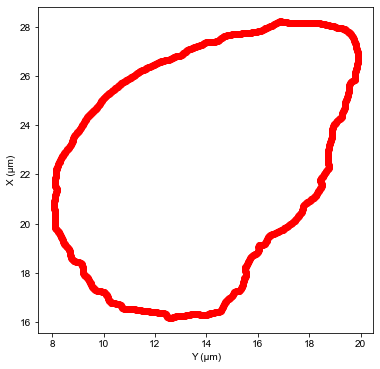

Processing: coordinates/cell5/34D-grid3-ActA1_003_16.txt


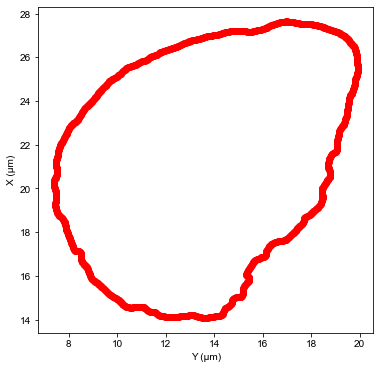

Processing: coordinates/cell5/34D-grid3-ActA1_004_16.txt


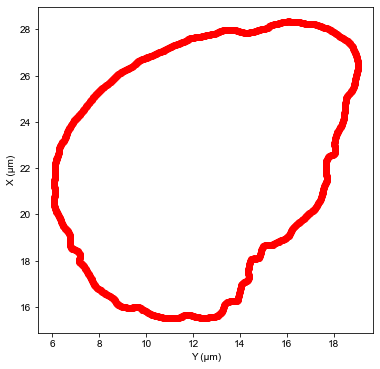

In [47]:
from scipy import interpolate

for file in files:
    print("Processing:", file)
    coords = np.loadtxt(file)
    coords = np.vstack((coords, coords[0]))  # Energy expects last point to equal first

    tck, u = interpolate.splprep([coords[:,0], coords[:,1]], s=0, per=True)
    xi, yi = interpolate.splev(np.linspace(0, 1, 1000), tck)

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.scatter(xi, yi, color="r")

    ax.set_ylabel(r"X (μm)")
    ax.set_xlabel(r"Y (μm)")
    plt.show()

    # x = coords[:,0]
    # y = coords[:,1]

    # dx = np.diff(x)
    # dy = np.diff(y)

    # print(np.sqrt(dx**2 +  dy**2))
